In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from skimage.io import imread
from skimage.transform import resize
import os

# Set paths to the images and masks
image_dir = 'N:\\My Drive\\Data\\RUH'
mask_dir = 'N:\\My Drive\\Data\\Mask'
# List of image and mask files
image_files = sorted(os.listdir(image_dir))[:15000]
mask_files = sorted(os.listdir(mask_dir))[:15000]

# Function to normalize images and encode masks
def prepare_data(img_path, mask_path):
    # Read the image and mask files
    img = imread(img_path) / 255.0  # Normalize to [0, 1]
    mask = imread(mask_path, as_gray=True)  # Read mask as grayscale
    # Resize images and masks if not already 256x256
    if img.shape[0] != 256 or img.shape[1] != 256:
        img = resize(img, (256, 256), anti_aliasing=True)
    if mask.shape[0] != 256 or mask.shape[1] != 256:
        mask = resize(mask, (256, 256), order=0, preserve_range=True)
    # Map mask pixel values to class labels
    mask[mask == 255] = 3
    mask[mask == 170] = 2
    mask[mask == 85] = 1
    mask[mask == 0] = 0
    # Convert mask to categorical
    mask = to_categorical(mask, num_classes=4)
    return img, mask

# Generator to load images in batches
def generate_batches(image_files, mask_files, batch_size):
    num_samples = len(image_files)
    while True:  # Loop indefinitely
        for start in range(0, num_samples, batch_size):
            end = min(start + batch_size, num_samples)
            images, masks = [], []
            for i in range(start, end):
                img_path = os.path.join(image_dir, image_files[i])
                mask_path = os.path.join(mask_dir, mask_files[i])
                img, mask = prepare_data(img_path, mask_path)
                images.append(img)
                masks.append(mask)
            yield np.array(images), np.array(masks)



In [2]:
from sklearn.model_selection import train_test_split
# Split the dataset into training and validation sets
image_files_train, image_files_val, mask_files_train, mask_files_val = train_test_split(
    image_files, mask_files, test_size=0.2, random_state=42)

# Define batch size
batch_size = 32

# Training and validation generator
train_generator = generate_batches(image_files_train, mask_files_train, batch_size)
val_generator = generate_batches(image_files_val, mask_files_val, batch_size)


In [3]:

from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate, Dropout
from tensorflow.keras.optimizers import Adam

def segnet_model(input_size=(256, 256, 3), num_classes=4):
    inputs = Input(input_size)

    # Encoder
    e1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    e1 = BatchNormalization()(e1)
    e2 = MaxPooling2D(pool_size=(2, 2))(e1)

    e2 = Conv2D(128, (3, 3), activation='relu', padding='same')(e2)
    e2 = BatchNormalization()(e2)
    e3 = MaxPooling2D(pool_size=(2, 2))(e2)

    e3 = Conv2D(256, (3, 3), activation='relu', padding='same')(e3)
    e3 = BatchNormalization()(e3)
    e4 = MaxPooling2D(pool_size=(2, 2))(e3)

    e4 = Conv2D(512, (3, 3), activation='relu', padding='same')(e4)
    e4 = BatchNormalization()(e4)
    e5 = MaxPooling2D(pool_size=(2, 2))(e4)

    # Decoder
    d1 = UpSampling2D(size=(2, 2))(e5)
    d1 = Conv2D(512, (3, 3), activation='relu', padding='same')(d1)
    d1 = BatchNormalization()(d1)

    d2 = UpSampling2D(size=(2, 2))(d1)
    d2 = Conv2D(256, (3, 3), activation='relu', padding='same')(d2)
    d2 = BatchNormalization()(d2)

    d3 = UpSampling2D(size=(2, 2))(d2)
    d3 = Conv2D(128, (3, 3), activation='relu', padding='same')(d3)
    d3 = BatchNormalization()(d3)

    d4 = UpSampling2D(size=(2, 2))(d3)
    d4 = Conv2D(64, (3, 3), activation='relu', padding='same')(d4)
    d4 = BatchNormalization()(d4)

    # Output layer
    outputs = Conv2D(num_classes, (1, 1), activation='softmax')(d4)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model


segnet = segnet_model()
segnet.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 256, 256, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256, 256, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128, 128, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64, 64, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 32, 32, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 32, 32, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 16, 16, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 32, 32, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 32, 32, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 64, 64, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 64, 64, 256)    │     1,179,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 64, 64, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_2 (UpSampling2D)  │ (None, 128, 128, 256)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 128, 128, 128)  │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 128, 128, 128)  │           51

 Total params: 5,467,460 (20.86 MB)

 Trainable params: 5,463,620 (20.84 MB)

 Non-trainable params: 3,840 (15.00 KB)

In [4]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Compile the model
segnet = segnet_model()
segnet.compile(
    optimizer='sgd',
    loss='mse',
    metrics=[tf.keras.metrics.IoU(num_classes=4, target_class_ids=[0])])

# Define callbacks for saving the model and early stopping
model_checkpoint = ModelCheckpoint('segnet_model.keras', monitor='val_loss', save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

# Training the model
history = segnet.fit(
    x=train_generator,
    epochs=15,
    steps_per_epoch=int(np.ceil(len(image_files_train) / batch_size)),
    validation_data=val_generator,
    validation_steps=int(np.ceil(len(image_files_val) / batch_size)),
    callbacks=[model_checkpoint, early_stopping]
)


Epoch 1/15
375/375 ━━━━━━━━━━━━━━━━━━━━ 5218s 14s/step - io_u: 0.7500 - loss: 0.1303 - val_io_u: 0.7500 - val_loss: 0.0367
Epoch 2/15
375/375 ━━━━━━━━━━━━━━━━━━━━ 5209s 14s/step - io_u: 0.7500 - loss: 0.0680 - val_io_u: 0.7500 - val_loss: 0.0501
Epoch 3/15
375/375 ━━━━━━━━━━━━━━━━━━━━ 5229s 14s/step - io_u: 0.7500 - loss: 0.0551 - val_io_u: 0.7500 - val_loss: 0.0470
Epoch 4/15
375/375 ━━━━━━━━━━━━━━━━━━━━ 5182s 14s/step - io_u: 0.7500 - loss: 0.0472 - val_io_u: 0.7500 - val_loss: 0.0413
Epoch 5/15
375/375 ━━━━━━━━━━━━━━━━━━━━ 5239s 14s/step - io_u: 0.7500 - loss: 0.0420 - val_io_u: 0.7500 - val_loss: 0.0375
Epoch 6/15
375/375 ━━━━━━━━━━━━━━━━━━━━ 5235s 14s/step - io_u: 0.7500 - loss: 0.0385 - val_io_u: 0.7500 - val_loss: 0.0350
Epoch 7/15
375/375 ━━━━━━━━━━━━━━━━━━━━ 5237s 14s/step - io_u: 0.7500 - loss: 0.0360 - val_io_u: 0.7500 - val_loss: 0.0332
Epoch 8/15
375/375 ━━━━━━━━━━━━━━━━━━━━ 5234s 14s/step - io_u: 0.7500 - loss: 0.0343 - val_io_u: 0.7500 - val_loss: 0.0318
Epoch 9/15
375/3

In [15]:
from tensorflow.keras.models import load_model

# Load the trained model from file
model = load_model('unet_segmentation_3.keras')


In [16]:
from skimage.io import imread
from skimage.transform import resize
import numpy as np
import os
import matplotlib.pyplot as plt

# Correct path to the single image file
test_image_path = "N:\\My Drive\\Data\\RUH\\RGB_RUH-All-Bands_2023-12-19_sub_300.png"
mask_image_path = "N:\\My Drive\\Data\\Mask\\MASK_RUH-All-Bands_2023-12-19_sub_300.png"

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step


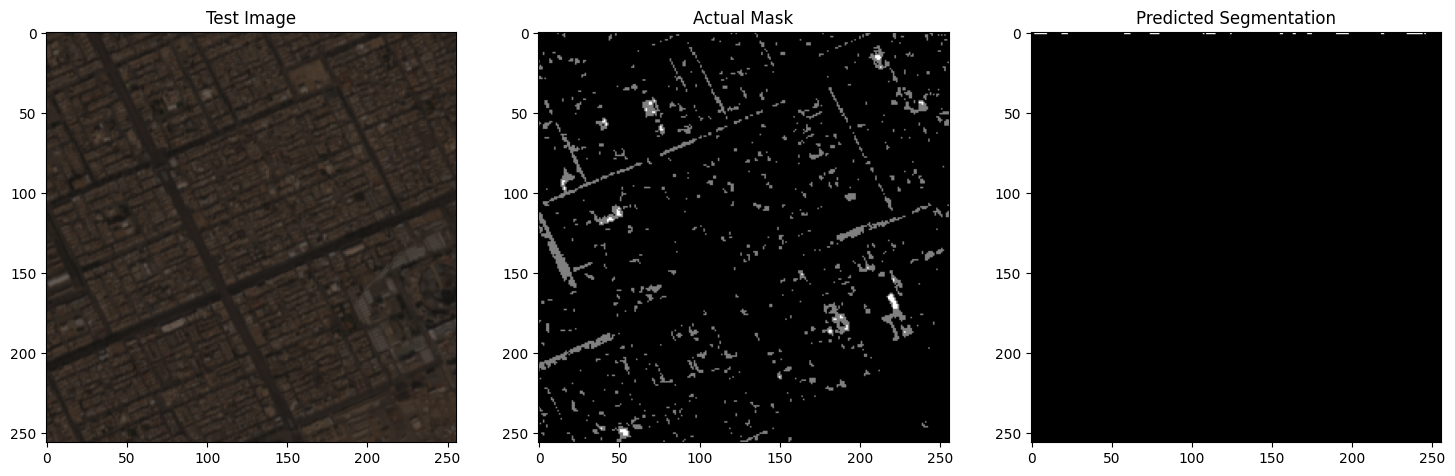

In [17]:


# Function to prepare and load the image
def prepare_image(file_path):
    img = imread(file_path)
    img = img / 255.0  # Normalize the image to [0, 1]
    if img.shape != (256, 256, 3):  # Check if resizing is needed
        img = resize(img, (256, 256), anti_aliasing=True)
    img = np.expand_dims(img, axis=0)  # Expand dimensions to fit model input
    return img

# Load the actual mask
actual_mask = imread(mask_image_path)
if actual_mask.shape != (256, 256):  # Resize if not already 256x256
    actual_mask = resize(actual_mask, (256, 256), anti_aliasing=True)

# Load and prepare the test image
test_image = prepare_image(test_image_path)

# Predict using the model
predicted_mask = model.predict(test_image)
predicted_mask = np.argmax(predicted_mask, axis=-1)  # Convert probabilities to class labels

# Display the image, actual mask, and predicted segmentation
plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 1)
plt.imshow(np.squeeze(test_image), cmap='gray')
plt.title('Test Image')

plt.subplot(1, 3, 2)
plt.imshow(actual_mask, cmap='gray')
plt.title('Actual Mask')

plt.subplot(1, 3, 3)
plt.imshow(np.squeeze(predicted_mask[0]), cmap='gray')
plt.title('Predicted Segmentation')
plt.show()

